In [1]:
import datetime
print('\nStart: ', datetime.datetime.now()) #Record script start time

import pandas as pd
from pandas import DataFrame

import numpy as np
np.random.seed(2018)

import nltk
nltk.download('wordnet')
from nltk.tokenize import *
from nltk.corpus import stopwords
from nltk.corpus import PlaintextCorpusReader
from nltk.stem import WordNetLemmatizer, SnowballStemmer
stemmer = SnowballStemmer('english')
from nltk.stem.porter import *
from nltk.probability import FreqDist

import gensim
from gensim import corpora
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.models import CoherenceModel

import preprocessLDA

[nltk_data] Downloading package wordnet to C:\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
#Read data
df = pd.read_json('goodreads_reviews_children.json', lines= True)

In [3]:
#Extract top 10 book_ids with the most number of reviews
top_books_valuecount = df.groupby('book_id').size().reset_index()
top_books_valuecount = top_books_valuecount.rename(columns = {0:'value_count'}).sort_values('value_count', ascending = False)
print(top_books_valuecount.head(10))
top_books_valuecount = top_books_valuecount['book_id'][:10].copy()

        book_id  value_count
88         3636         6156
0             5         4696
74564  11387515         4499
4678     157993         3114
2403      78411         1999
70142   9673436         1947
323        8127         1721
9794     370493         1697
75083  11594337         1575
54         2998         1524


In [4]:
#Dataframe of these top book_ids
df_top_books = df[df['book_id'].isin(top_books_valuecount)]
df_top_books

,user_id,book_id,review_id,rating,review_text,date_added,date_updated,read_at,started_at,n_votes,n_comments
46,7b2e5fe9fd353fecf3eeebb4850b88d3,11594337,0cef00e7ac5b37c459c94083475413f7,5,"great story, heartwarming and very current wit...",Sat Jan 05 17:30:28 -0800 2013,Sun Jan 27 19:35:53 -0800 2013,,,0,0
54,0ef32090550901ead25cb0ea21c4d36b,157993,f379671d83939b72314ef2439d44e372,4,I read this in French during high school (Fren...,Wed Nov 21 16:45:09 -0800 2012,Wed Nov 21 16:45:46 -0800 2012,,,0,0
63,d37b46b2190ed7c518259f29b47a9b36,3636,ac7aae56c65adfde94bb8a9e653f67d3,5,A quick but engrossing dystopian novel. The re...,Thu Mar 30 11:33:22 -0700 2017,Thu Mar 30 18:10:44 -0700 2017,Thu Mar 30 00:00:00 -0700 2017,Wed Mar 29 00:00:00 -0700 2017,4,0
70,f4c6fe33ef61c38f7f4aeb5224c259a5,11387515,13f03d0906f27f5202865787efdf1bbc,4,I love how simple the story was told but the m...,Sun Nov 04 00:40:58 -0700 2012,Mon Nov 12 04:14:02 -0800 2012,Mon Nov 12 04:14:02 -0800 2012,Sun Nov 04 00:00:00 -0700 2012,0,0
71,f4c6fe33ef61c38f7f4aeb5224c259a5,157993,45c234cd783da040e9da8c3e81df0297,5,We should see with our hearts not with our eye...,Fri Nov 02 07:37:50 -0700 2012,Fri Apr 26 06:56:47 -0700 2013,,,1,0
...,...,...,...,...,...,...,...,...,...,...,...
734590,8970fe60796274ca4b58eeabfe6fb78e,5,a6a0628171a2dea1c09f87032ffb02d8,5,Love the books,Thu Nov 24 02:51:32 -0800 2016,Thu Nov 24 02:52:39 -0800 2016,Fri Jan 01 00:00:00 -0800 2016,Fri Jan 01 00:00:00 -0800 2016,0,0
734606,31a2c453c1742edd9732dff77ffc8a50,11387515,a5761512de5a6f1af1b60065e88924c6,5,Awesome book about the imperfections of humani...,Fri Mar 30 07:42:41 -0700 2012,Fri Mar 30 07:47:29 -0700 2012,Tue Mar 27 00:00:00 -0700 2012,,0,0
734613,ce27420f5dbfcecc92057a4000345027,2998,261b1729ad5c4331ca5ea490f4a0dea0,3,I was great to read an old classic that i reme...,Thu May 31 12:00:25 -0700 2012,Thu May 31 12:01:19 -0700 2012,,,0,0
734624,354ffdcbf956c820137b85bf8b957b9e,157993,84f15a500176f5c26d799614001bcc75,4,It's quite difficult for a layman like me to r...,Sat Jun 02 11:21:30 -0700 2012,Tue Jun 05 11:44:33 -0700 2012,Mon Jun 04 00:00:00 -0700 2012,Sat Jun 02 00:00:00 -0700 2012,0,0


In [10]:
#Takes about 2 min to run
#Tokenize, stopword removal, Lemmatize
def PreProcess(raw_string):
    from nltk.corpus import stopwords
    from nltk.tokenize import TweetTokenizer
    #from nltk.stem import WordNetLemmatizer
    from nltk.tokenize import casual_tokenize
    from nltk.stem import PorterStemmer
    ps = PorterStemmer()
    tokenizer = TweetTokenizer(strip_handles=True, reduce_len=True)
    #lemmatizer = WordNetLemmatizer()
    m1 = re.compile(r'#[a-zA-Z0-9]+\b') #remove hashtag
    m2 = re.compile(r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)') # remove website
    m3 = re.compile(r'[0-9][a-zA-Z0-9\/,\]]+\b') #remove numbers & dates
    m4 = re.compile(r'[-:\\\)\(<>_@=\';\[]+') #remove emoticons
    m5 = re.compile(r'[.\\]n?') #remove new lines
    word = stopwords.words('english')
    word.extend(['book', 'read', 'story'])
    p1 = re.sub(m1, '', raw_string)
    p2 = re.sub(m2, '', p1)
    p3 = re.sub(m3, '', p2)
    p4 = re.sub(m4, '', p3)
    p5 = re.sub(m5, '', p4)
    token_sent = tokenizer.tokenize(p5)
    #apply stopwords again after tokenising as more stop words may have been created after tokenising.
    word = stopwords.words('english')
    word.extend(['book', 'read', 'story', 'dengan', 'orang', 'itu', 'tidak', 'dari', 'di', 'buku', 'ini', 'dan', 'yang', 'saya', 'por', 'est', 'como', 'si', 'con', 'es', 'lo', 'libro', 'la', 'que', 'bh', 'khh', 'mn'])
    token_sent = [w.lower() for w in token_sent if w.lower() not in word]
    tagged = nltk.pos_tag(token_sent)
    selection_tags = ['NN', 'NNS', 'NNP', 'NNPS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'] #selected tags
    
    words_to_combine = []
    for word, tag in tagged: #choosing of words in tags
        if tag in selection_tags:
            words_to_combine.append((word))
    stem = [ps.stem(w.lower()) for w in words_to_combine]
    return [w for w in stem if len(w)>1]

df_top_books['Processed'] = df_top_books['review_text'].apply(lambda x: PreProcess(x))

#Add preprocessed text into a new column in the dataframe
df_top_books.sort_values(by='book_id', ascending=False)

,user_id,book_id,review_id,rating,review_text,date_added,date_updated,read_at,started_at,n_votes,n_comments,Processed,Processed_2
46,7b2e5fe9fd353fecf3eeebb4850b88d3,11594337,0cef00e7ac5b37c459c94083475413f7,5,"great story, heartwarming and very current wit...",Sat Jan 05 17:30:28 -0800 2013,Sun Jan 27 19:35:53 -0800 2013,,,0,0,"[heartwarm, right, circl, titl, daunt, reader,...",heartwarm right circl titl daunt reader girth ...
55028,b48ef05b19ab6367ac614de4b3ecd6f8,11594337,3d63051854f5b6b1839fe289e019a709,4,Such a sweet book. Watch out because these cha...,Mon Oct 26 03:54:12 -0700 2015,Sat Nov 21 07:11:09 -0800 2015,,,0,0,"[watch, charm, charact, heart]",watch charm charact heart
421243,1806909867ba2601d59b1d6d8354dd5a,11594337,306b7f9671563f08d99ee513375a38a3,5,"Beautiful, compelling book about animals in ca...",Thu Sep 08 22:12:07 -0700 2016,Mon Jan 30 08:21:34 -0800 2017,Tue Jan 10 00:00:00 -0800 2017,,0,0,"[beauti, compel, anim, captiv, cruelti, compas...",beauti compel anim captiv cruelti compass love
723312,16c1d30d249783e3bf7268c1b35ad0de,11594337,10447324bdf79f9e82ff4809aec10aa7,4,Great book. Great story. Great characters.,Sun May 03 18:52:26 -0700 2015,Sun May 03 18:52:59 -0700 2015,,,0,0,[charact],charact
279045,172e550a3e12dbf139735e8542dbd780,11594337,4841422b2d622f10b94d1a7ab037ee34,5,Beautiful book for young and not as young.,Mon Dec 29 20:45:17 -0800 2014,Mon Dec 29 20:46:13 -0800 2014,,,0,0,[],
...,...,...,...,...,...,...,...,...,...,...,...,...,...
625623,b3571369f5778a5597b0b741a034d579,5,2b204c56e2e6688c44b194fbb9af66c8,3,see book 1,Tue Jun 11 20:57:03 -0700 2013,Wed Jul 17 13:22:50 -0700 2013,,,0,0,[see],see
625567,552404b1ae8a33f3dd0c03e2c02c429c,5,ab8bf46bb94898e3ac15efbadcb20bbb,4,"Let me start off by saying I really, really li...",Fri Aug 03 11:29:26 -0700 2012,Thu Aug 09 08:18:18 -0700 2012,Thu Aug 09 08:18:18 -0700 2012,Fri Aug 03 00:00:00 -0700 2012,1,1,"[let, start, say, chamber, secret, find, chara...",let start say chamber secret find charact deve...
301455,77f116093b800df44715cadc542a7241,5,1975fe80bff363ef9d54e8af1e6858bf,4,"My least favorite of the series, but still good.",Sat Jan 18 13:34:15 -0800 2014,Sun Mar 30 13:55:56 -0700 2014,,,0,0,[seri],seri
301549,44bba487f50143fd66d88c1e94c840c7,5,6fd54898fc22f75b014cff126236d979,4,The first signs of the series getting dark sha...,Sat Dec 31 07:52:46 -0800 2011,Sun Jan 01 06:35:16 -0800 2012,Sun Jan 01 00:00:00 -0800 2012,Sat Dec 31 00:00:00 -0800 2011,1,0,"[sign, seri, get, shade, begin, grow, gestur, ...",sign seri get shade begin grow gestur word chi...


In [11]:
df_top_books = df_top_books.dropna(subset=['Processed']) #remove comments that have 0 processed words

In [12]:
df_top_books['Processed_2'] = df_top_books['Processed'].apply(lambda x: ' '.join([t for t in x]))

In [13]:
#This chunk takes about 2 hours to run.
print('\nStart LDA: ', datetime.datetime.now()) #Record LDA start time

init_topic = 1
no_of_topics = 21 #Generate 20 models of 1 to 20 topics
topic_step = 1
no_of_words = 10 #LDA to output top 10 words of each topic

book_topics = []
model_list = []
book_id_list = []
coherence_values = []
model_topics = []

#Perform LDA, compute coherence score
for v in top_books_valuecount: #Iterate the LDA and coherence codes through each book_id.
    dataframe = df_top_books[df_top_books['book_id'] == v]
    print('\nBook_id:', v)
    for n_topics in range(init_topic, no_of_topics, topic_step): #generate the 20 LDA models for each book_id
        book_dictionary = gensim.corpora.Dictionary(dataframe['Processed'])
        book_vecs = preprocessLDA.docs2vecs(df_top_books['Processed'], book_dictionary)
        book_lda = gensim.models.ldamodel.LdaModel(corpus=book_vecs, id2word = book_dictionary, num_topics = n_topics)
        topics = book_lda.show_topics(no_of_topics, no_of_words)
        book_topics.append(topics)

        #Compute coherence score
        coherence_model_lda = CoherenceModel(model = book_lda, texts = dataframe['Processed'], dictionary = book_dictionary, coherence = 'c_v')
        coherence_score = coherence_model_lda.get_coherence()        
        model_topics.append(n_topics)
        model_list.append(book_lda)
        coherence_values.append(coherence_score)

        book_id_list.append(v)

        # print output
        print("Number of topics: ", str(n_topics), '\nCoherence Score: ', coherence_score)

coherence_values_array = np.array(coherence_values)
book_id_list_array = np.array(book_id_list)
model_topics_array = np.array(model_topics)

print('\nEnd LDA: ', datetime.datetime.now()) #Record LDA end time


Start LDA:  2021-07-24 08:54:28.066589

Book_id: 3636
Number of topics:  1 
Coherence Score:  0.4492639865765449
Number of topics:  2 
Coherence Score:  0.6068131011163082
Number of topics:  3 
Coherence Score:  0.5856963335498551
Number of topics:  4 
Coherence Score:  0.6039586365521784
Number of topics:  5 
Coherence Score:  0.5771911914571926
Number of topics:  6 
Coherence Score:  0.5612799729366628
Number of topics:  7 
Coherence Score:  0.5746400315255081
Number of topics:  8 
Coherence Score:  0.6040493674480827
Number of topics:  9 
Coherence Score:  0.5143677441306491
Number of topics:  10 
Coherence Score:  0.5275623611728635
Number of topics:  11 
Coherence Score:  0.5380403188393562
Number of topics:  12 
Coherence Score:  0.5441758647460228
Number of topics:  13 
Coherence Score:  0.5487638545245243
Number of topics:  14 
Coherence Score:  0.5328076523925839
Number of topics:  15 
Coherence Score:  0.5522474921956494
Number of topics:  16 
Coherence Score:  0.52400659692

Number of topics:  16 
Coherence Score:  0.46669928742622036
Number of topics:  17 
Coherence Score:  0.4497377462339516
Number of topics:  18 
Coherence Score:  0.48914182776730425
Number of topics:  19 
Coherence Score:  0.46306366474623384
Number of topics:  20 
Coherence Score:  0.5152000432504794

Book_id: 370493
Number of topics:  1 
Coherence Score:  0.5474775944534302
Number of topics:  2 
Coherence Score:  0.5607019833752502
Number of topics:  3 
Coherence Score:  0.565216298687287
Number of topics:  4 
Coherence Score:  0.510929333695436
Number of topics:  5 
Coherence Score:  0.5140977412216403
Number of topics:  6 
Coherence Score:  0.4960098903793046
Number of topics:  7 
Coherence Score:  0.5228058135458482
Number of topics:  8 
Coherence Score:  0.5288599279967159
Number of topics:  9 
Coherence Score:  0.5607170186648888
Number of topics:  10 
Coherence Score:  0.5503199681131786
Number of topics:  11 
Coherence Score:  0.529364635236758
Number of topics:  12 
Coherence

In [14]:
#Generate the coherence score results
df_coherence = DataFrame (coherence_values_array, columns=['coherence_score'])
df_book_id = DataFrame (book_id_list_array, columns=['book_id'])
df_model_topics = DataFrame (model_topics_array, columns=['n_topics'])

df_coherence['book_id'] = df_book_id
df_coherence['n_topics'] = df_model_topics
df_coherence['coherence_score'] = df_coherence

df_coherence = df_coherence[['book_id', 'n_topics', 'coherence_score']]

df_coherence

#Save output into a CSV file
pd.DataFrame(df_coherence).to_csv("LDA_coherence_scores.csv")

book_id
5           AxesSubplot(0.125,0.125;0.775x0.755)
2998        AxesSubplot(0.125,0.125;0.775x0.755)
3636        AxesSubplot(0.125,0.125;0.775x0.755)
8127        AxesSubplot(0.125,0.125;0.775x0.755)
78411       AxesSubplot(0.125,0.125;0.775x0.755)
157993      AxesSubplot(0.125,0.125;0.775x0.755)
370493      AxesSubplot(0.125,0.125;0.775x0.755)
9673436     AxesSubplot(0.125,0.125;0.775x0.755)
11387515    AxesSubplot(0.125,0.125;0.775x0.755)
11594337    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

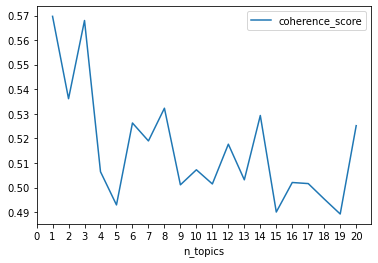

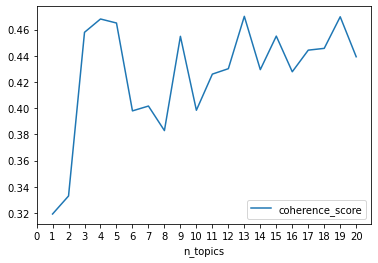

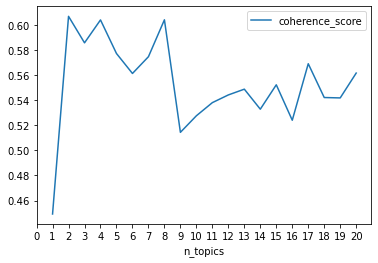

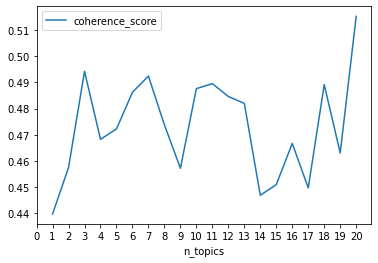

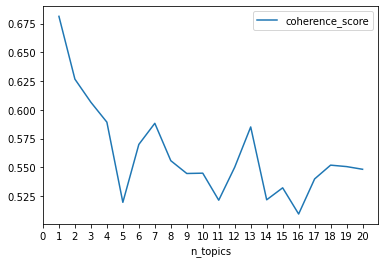

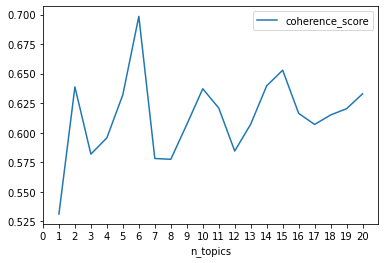

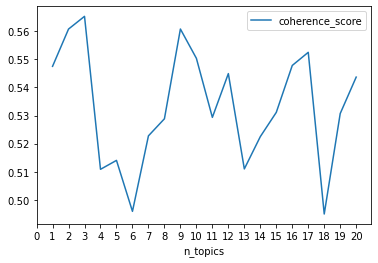

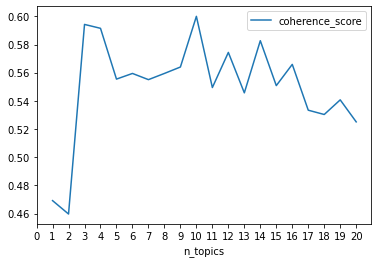

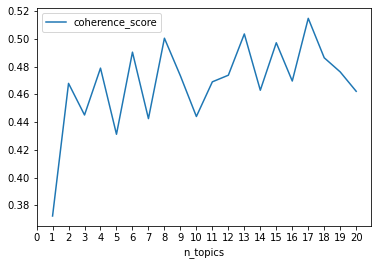

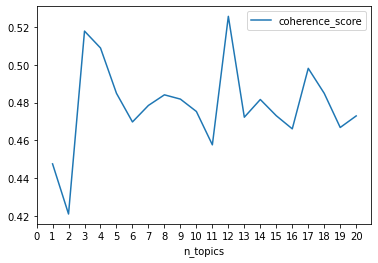

In [15]:
# Generate coherence score plots
df_coherence.groupby('book_id').plot(x='n_topics', y='coherence_score', legend=True, xticks=np.arange(0, 21, step=1))

In [16]:
#Print out LDA output
book_topics

[[(0,
   '0.018*"love" + 0.012*"time" + 0.010*"book" + 0.010*"think" + 0.009*"read" + 0.009*"charact" + 0.008*"end" + 0.008*"make" + 0.008*"seri" + 0.007*"children"')],
 [(0,
   '0.019*"love" + 0.016*"book" + 0.016*"time" + 0.013*"read" + 0.012*"seri" + 0.011*"think" + 0.011*"harri" + 0.011*"charact" + 0.010*"end" + 0.010*"get"'),
  (1,
   '0.017*"love" + 0.012*"life" + 0.011*"school" + 0.010*"peopl" + 0.009*"world" + 0.009*"make" + 0.009*"jona" + 0.008*"kid" + 0.007*"think" + 0.007*"kind"')],
 [(0,
   '0.009*"el" + 0.008*"shi" + 0.007*"para" + 0.007*"da" + 0.006*"est" + 0.006*"che" + 0.005*"te" + 0.005*"su" + 0.005*"kai" + 0.005*"se"'),
  (1,
   '0.030*"love" + 0.018*"book" + 0.018*"time" + 0.014*"seri" + 0.014*"read" + 0.012*"think" + 0.012*"charact" + 0.012*"harri" + 0.011*"get" + 0.010*"end"'),
  (2,
   '0.014*"world" + 0.014*"life" + 0.010*"make" + 0.009*"jona" + 0.009*"live" + 0.008*"think" + 0.008*"peopl" + 0.008*"feel" + 0.007*"thing" + 0.007*"children"')],
 [(0,
   '0.038*"lov

In [18]:
#Save output into a CSV file
pd.DataFrame(book_topics).to_csv("LDA_topic_extraction.csv")

print('\nEnd: ', datetime.datetime.now()) #Record script end time


End:  2021-07-24 10:53:58.811199
